In [15]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Wrangling

We are interested in predicting apartment prices in Buenos Aires (`"Capital Federal"`) that cost less than $400,000. First we will filter the data to extract what we need

We create a function to handle data wrangling since that data have the same structure. We can pass the file through the functino to process it faster

In [10]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Subset data: Apartment, Capital Federal, < $400,000
    mask_1 = df['property_type'] == 'apartment'
    mask_2 = df['place_with_parent_names'].str.contains('Capital Federal')
    mask_3 = df['price_aprox_usd'] < 400000

    df = df[mask_1 & mask_2 & mask_3]

    # Remove outliers in surface_covered_in_m2
    area_low, area_high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(area_low, area_high)

    df = df[mask_area]

    # Split lat-lon column
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand = True).astype(float)
    df.drop(['lat-lon'], axis=1, inplace=True)

    # Get neighborhood name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    df['neighborhood'] = df['neighborhood'].str.replace('nan', '')

    # Remove column with > 50% NaN
    for col in df.columns:
        null_count = df[col].isna().sum()
        if null_count > df.shape[0]/2:
            df.drop([col], axis=1, inplace=True)
    
    # Remove low and high cardinal columns
    df.drop(['operation', 'property_type', 'currency', 'properati_url'], axis=1, inplace=True)

    # Remove leakage
    df.drop(['price', 'price_aprox_local_currency', 'price_usd_per_m2', 'price_per_m2'], axis=1, inplace=True)

    #Remove correlated col
    df.drop(['surface_total_in_m2', 'rooms'], axis=1, inplace=True)
    
    return df

In [53]:
df = wrangle('data/buenos-aires-real-estate-1.csv')
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [23]:
# Before
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
count,1.781000e+03,1.781000e+03,1781.000000,1247.000000,1635.000000,1198.000000,1618.000000,482.000000,1385.000000
mean,2.285410e+05,2.178037e+06,143647.215239,114.417001,97.877064,2231.534726,4340.345113,10.085062,2.434657
std,4.100189e+05,1.141710e+06,75298.758506,1755.263895,1533.057610,650.139587,8126.940810,44.783320,1.065193
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.224587,1.000000,1.000000
25%,9.000000e+04,1.349454e+06,89000.000000,40.000000,38.000000,1815.485830,1973.750000,2.000000,2.000000
50%,1.300000e+05,1.849813e+06,122000.000000,55.000000,50.000000,2151.642336,2411.239496,4.000000,2.000000
75%,1.911340e+05,2.653420e+06,175000.000000,79.000000,73.000000,2577.003583,2958.157462,7.000000,3.000000
max,5.487000e+06,6.034635e+06,398000.000000,62034.000000,62034.000000,5975.609756,57156.250000,616.000000,6.000000


It looks like `surface_covered_in_m2` contains outlier. Looking at the statistic, while most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters. We will modify our `wrangle` function to remove the outliers

In [26]:
# After
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
count,1.343000e+03,1.343000e+03,1343.000000,965.000000,1343.000000,927.000000,1343.000000,379.000000,1078.000000
mean,2.204582e+05,2.054927e+06,135527.838719,59.883938,55.076694,2244.163063,4285.479770,11.155673,2.364564
std,4.151182e+05,9.033095e+05,59575.630208,26.621969,18.160427,639.740608,7987.685558,50.138692,0.902759
min,2.727900e+04,4.136151e+05,27279.000000,0.000000,31.000000,513.513514,808.148936,1.000000,1.000000
25%,9.325000e+04,1.394941e+06,92000.000000,42.000000,40.000000,1826.505017,1975.872093,2.000000,2.000000
50%,1.259000e+05,1.819935e+06,120029.460000,55.000000,50.000000,2141.519231,2411.764706,4.000000,2.000000
75%,1.750000e+05,2.425984e+06,160000.000000,75.000000,68.500000,2578.183144,2964.814815,7.000000,3.000000
max,5.487000e+06,5.989148e+06,395000.000000,229.000000,100.000000,5777.777778,57156.250000,616.000000,6.000000


(array([246., 240., 223., 136., 130., 107.,  84.,  79.,  47.,  51.]),
 array([ 31. ,  37.9,  44.8,  51.7,  58.6,  65.5,  72.4,  79.3,  86.2,
         93.1, 100. ]),
 <BarContainer object of 10 artists>)

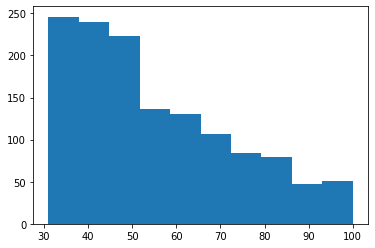

In [27]:
plt.hist(df['surface_covered_in_m2'])

We need to split the `lat-lon` column into 2 separate columns to fit our model. We will go back and modify the `wrangle` function again to do this

In [31]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

We create another column which contains the neighborhood that the apartments lie in. We will split the `place_with_parent_names` to get the neighborhood names

In [35]:
df['neighborhood']

4          Chacarita
9         Villa Luro
29         Caballito
40      Constitución
41              Once
            ...     
8589        Barracas
8590         Almagro
8593        Barracas
8601     San Nicolás
8604           Boedo
Name: neighborhood, Length: 1343, dtype: object

# Data Exploration

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   price                       1343 non-null   float64
 3   currency                    1343 non-null   object 
 4   price_aprox_local_currency  1343 non-null   float64
 5   price_aprox_usd             1343 non-null   float64
 6   surface_total_in_m2         965 non-null    float64
 7   surface_covered_in_m2       1343 non-null   float64
 8   price_usd_per_m2            927 non-null    float64
 9   price_per_m2                1343 non-null   float64
 10  floor                       379 non-null    float64
 11  rooms                       1078 non-null   float64
 12  expenses                    349 non-null    object 
 13  properati_url               1343 

We first deal with missing data. While we can remove rows that have missing data, it's not preferable as the more data we have the better the model. We will remove any columns that have more than 50% of the data missing

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   price                       1343 non-null   float64
 3   currency                    1343 non-null   object 
 4   price_aprox_local_currency  1343 non-null   float64
 5   price_aprox_usd             1343 non-null   float64
 6   surface_total_in_m2         965 non-null    float64
 7   surface_covered_in_m2       1343 non-null   float64
 8   price_usd_per_m2            927 non-null    float64
 9   price_per_m2                1343 non-null   float64
 10  rooms                       1078 non-null   float64
 11  properati_url               1343 non-null   object 
 12  lat                         1300 non-null   float64
 13  lon                         1300 

We removed 2 columns from our data: expenses and floor

Next we look at categorical columns with **low** and **high cardinality**. If a catergorical features are the same or unique for every observation, it won't have much meaning during training as it doesn't give us any useful information.

In [40]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    1343
neighborhood       53
dtype: int64

We will remove `operation`, `property_type` and `properati_url`. For `currency` although it's not the same for every observation, but it has only to values: USD and local currency, we will also remove it

In [44]:
df.select_dtypes("object").nunique()

neighborhood    53
dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       1343 non-null   float64
 1   price_aprox_local_currency  1343 non-null   float64
 2   price_aprox_usd             1343 non-null   float64
 3   surface_total_in_m2         965 non-null    float64
 4   surface_covered_in_m2       1343 non-null   float64
 5   price_usd_per_m2            927 non-null    float64
 6   price_per_m2                1343 non-null   float64
 7   rooms                       1078 non-null   float64
 8   lat                         1300 non-null   float64
 9   lon                         1300 non-null   float64
 10  neighborhood                1343 non-null   object 
dtypes: float64(10), object(1)
memory usage: 125.9+ KB


We then remove leakage, columns that were created using our target variable: `price`, `price_aprox_local_currency`, `price_usd_per_m2`, `price_per_m2`

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1343 non-null   float64
 1   surface_total_in_m2    965 non-null    float64
 2   surface_covered_in_m2  1343 non-null   float64
 3   rooms                  1078 non-null   float64
 4   lat                    1300 non-null   float64
 5   lon                    1300 non-null   float64
 6   neighborhood           1343 non-null   object 
dtypes: float64(6), object(1)
memory usage: 83.9+ KB


Lastly, we look for multicollinearity. We will only keep one features if there are strong correlation bewteen features as they basically mean the same thing

<AxesSubplot:>

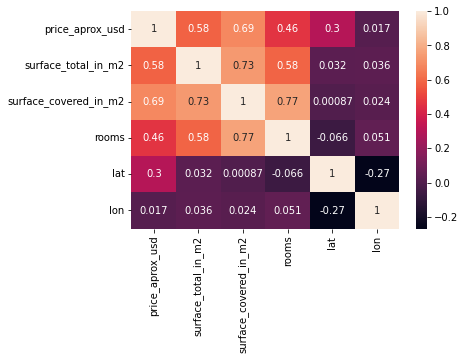

In [50]:
sns.heatmap(df.corr(), annot=True)

Since `surface_total_in_m2`, `surface_covered_in_m2` and `rooms` have high correlation with each other, we will only keep one of them: `surface_covered_in_m2`

<AxesSubplot:>

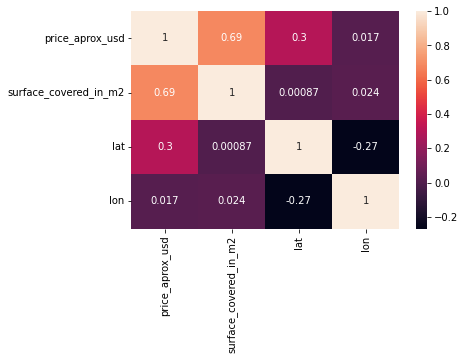

In [54]:
sns.heatmap(df.corr(), annot=True)

In [11]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

In [12]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [13]:
df.to_csv('data/buenos-aires-real-estate-clean.csv')